In [1]:
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2024-06-20 16:47:11--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  3.66MB/s    in 1.3s    

2024-06-20 16:47:13 (3.66 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [3]:
df = pd.read_csv('bbc_text_cls.csv')

In [4]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
df["targets"] = df["labels"].astype("category").cat.codes

In [6]:
# number of classes
K = df["targets"].max() + 1
K

5

In [7]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [8]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train["text"])
sequences_train = tokenizer.texts_to_sequences(df_train["text"])
sequences_test = tokenizer.texts_to_sequences(df_test["text"])

In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens." % V)

Found 27746 unique tokens.


In [10]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor:", data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (1557, 3482)


In [11]:
data_test = pad_sequences(sequences_test, maxlen=T)
print("Shape of data test tensor:", data_test.shape)

Shape of data test tensor: (668, 3482)


In [12]:
# Create the model

# We get to choose embedding dimensionality
D = 50

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [13]:
# Compile and fit
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

In [14]:
print("Training model...")
r = model.fit(
    data_train,
    df_train["targets"],
    epochs=50,
    validation_data=(data_test, df_test["targets"])
)

Training model...
Epoch 1/50
49/49 [==============================] - 17s 207ms/step - loss: 1.5786 - accuracy: 0.3276 - val_loss: 1.5108 - val_accuracy: 0.4940
Epoch 2/50
49/49 [==============================] - 16s 334ms/step - loss: 1.3579 - accuracy: 0.7881 - val_loss: 1.1939 - val_accuracy: 0.8802
Epoch 3/50
49/49 [==============================] - 10s 194ms/step - loss: 0.8831 - accuracy: 0.9306 - val_loss: 0.6749 - val_accuracy: 0.9102
Epoch 4/50
49/49 [==============================] - 4s 92ms/step - loss: 0.4300 - accuracy: 0.9493 - val_loss: 0.3849 - val_accuracy: 0.9251
Epoch 5/50
49/49 [==============================] - 3s 59ms/step - loss: 0.2367 - accuracy: 0.9685 - val_loss: 0.2800 - val_accuracy: 0.9371
Epoch 6/50
49/49 [==============================] - 2s 50ms/step - loss: 0.1546 - accuracy: 0.9788 - val_loss: 0.2295 - val_accuracy: 0.9461
Epoch 7/50
49/49 [==============================] - 2s 40ms/step - loss: 0.1087 - accuracy: 0.9839 - val_loss: 0.2018 - val_accura

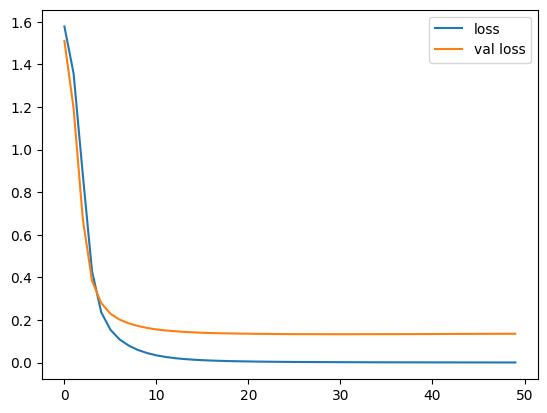

In [16]:
# Plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend();

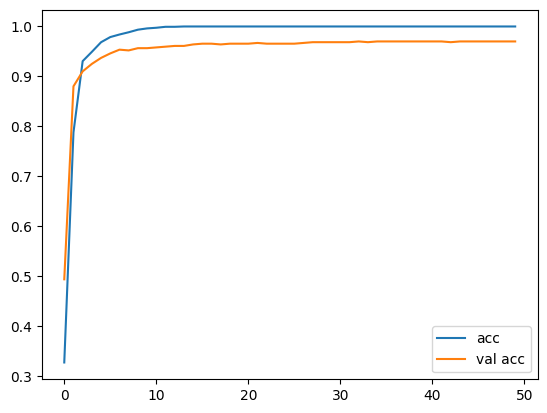

In [15]:
# Plot accuracy per iteration
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="val acc")
plt.legend();